<a href="https://colab.research.google.com/github/cataalbu/dentistry-hub-ai/blob/main/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import csv
import shutil

def create_folder_structure(csv_path, destination_folder):
    if not os.path.exists(destination_folder):
        os.makedirs(destination_folder)

    with open(csv_path, 'r') as csvfile:
        csv_reader = csv.reader(csvfile)
        next(csv_reader)
        for row in csv_reader:
            image_path, image_class = row
            image_class_folder = os.path.join(destination_folder, image_class)

            if not os.path.exists(image_class_folder):
                os.makedirs(image_class_folder)

            image_file_name = os.path.basename(image_path)

            shutil.copy("images/" + image_path, os.path.join(image_class_folder, image_file_name))

    print("Folder structure created successfully.")

# Example usage:
csv_file_path = 'data.csv'
output_folder = 'dataset/'

create_folder_structure(csv_file_path, output_folder)

Folder structure created successfully.


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

In [ ]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

dataset = tf.keras.utils.image_dataset_from_directory("dataset",
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)


Found 240 files belonging to 4 classes.


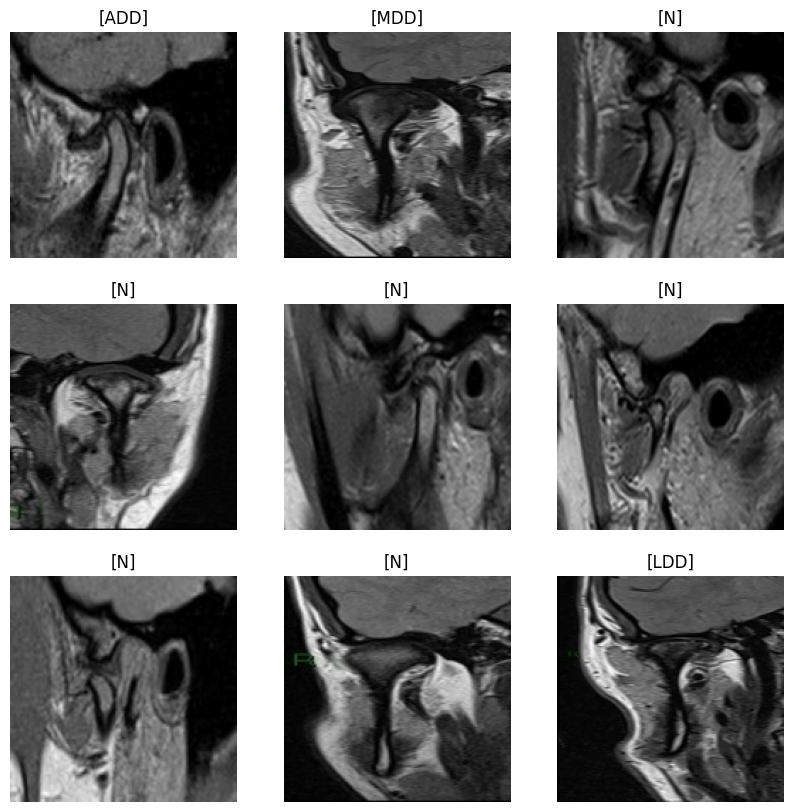

In [ ]:
class_names = dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [ ]:
num_batches = tf.data.experimental.cardinality(dataset)
train_dataset = dataset.take(6)
test_dataset = dataset.skip(6)


In [ ]:
print('Number of train batches: %d' % tf.data.experimental.cardinality(train_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))
#print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))



Number of train batches: 6
Number of test batches: 2


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
#validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)


In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])


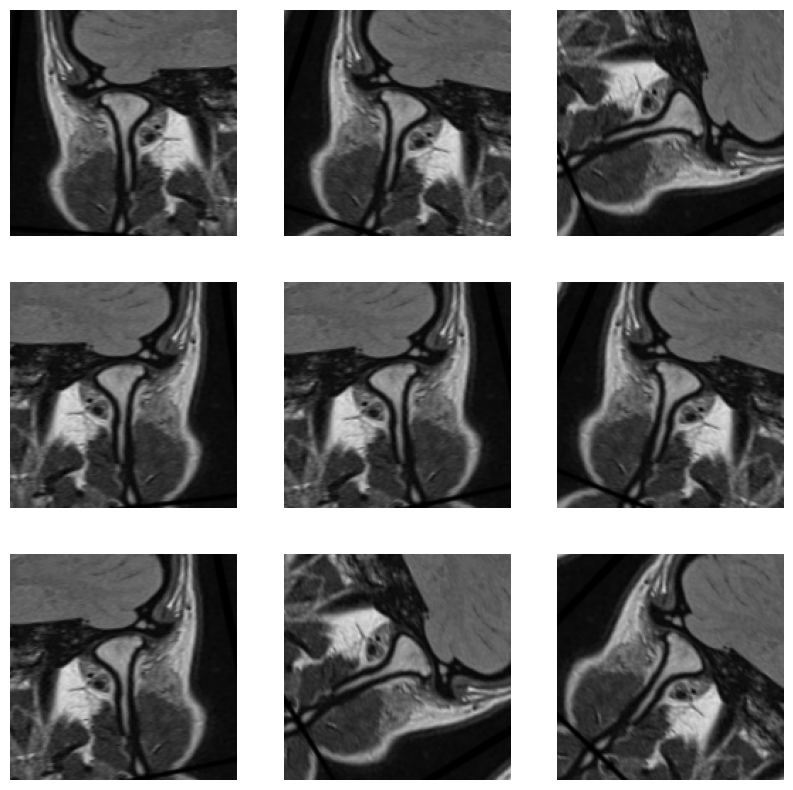

In [ ]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')


In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [ ]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)


In [ ]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')


9406464/9406464 [==============================] - 1s 0us/step


In [ ]:
base_model.trainable = False


In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)


(32, 5, 5, 1280)


In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)


(32, 1280)


In [ ]:
block_2 = tf.keras.Sequential([
    tf.keras.layers.Dense(1024, activation=tf.nn.silu),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(1024, activation=tf.nn.silu),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(1024, activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(1024, activation=tf.nn.silu),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(1024, activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(1024, activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(1024, activation=tf.nn.silu),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(1024, activation=tf.nn.silu),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(1024, activation=tf.nn.relu)
])
block2_batch = block_2(feature_batch_average)
print(block2_batch.shape)

(32, 1024)


In [ ]:
prediction_layer = tf.keras.layers.Dense(4, activation='softmax')
prediction_batch = prediction_layer(block2_batch)
print(prediction_batch.shape)


(32, 4)


In [ ]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = block_2(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)


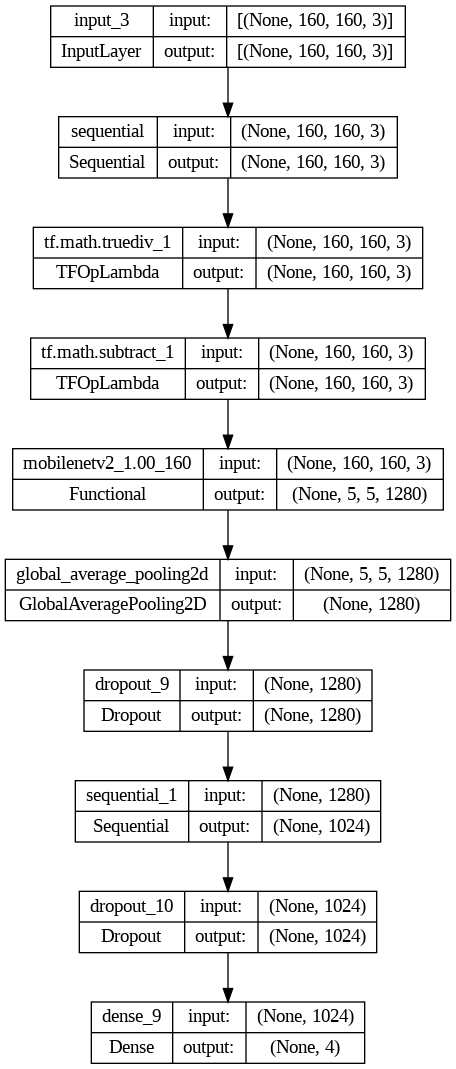

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)


In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy']
)

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    min_delta=0.0001,
    patience=20,
    restore_best_weights=True,
)

In [ ]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)


1/1 [==============================] - 3s 3s/step - loss: 3.0601 - accuracy: 0.0000e+00


In [ ]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))


initial loss: 3.06
initial accuracy: 0.00


In [ ]:
history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=500,
    callbacks=[early_stopping]
)
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()

Epoch 1/500
6/6 [==============================] - 16s 1s/step - loss: 1.2500 - accuracy: 0.4844 - val_loss: 0.9947 - val_accuracy: 0.5625
Epoch 2/500
6/6 [==============================] - 9s 2s/step - loss: 1.1077 - accuracy: 0.5729 - val_loss: 1.0205 - val_accuracy: 0.6458
Epoch 3/500
6/6 [==============================] - 6s 1s/step - loss: 1.0844 - accuracy: 0.5312 - val_loss: 1.0746 - val_accuracy: 0.6042
Epoch 4/500
6/6 [==============================] - 9s 2s/step - loss: 1.0789 - accuracy: 0.5312 - val_loss: 1.0226 - val_accuracy: 0.5417
Epoch 5/500
6/6 [==============================] - 6s 1s/step - loss: 0.9910 - accuracy: 0.5677 - val_loss: 0.9186 - val_accuracy: 0.6458
Epoch 6/500
6/6 [==============================] - 9s 2s/step - loss: 0.9488 - accuracy: 0.5521 - val_loss: 0.9676 - val_accuracy: 0.3958
Epoch 7/500
6/6 [==============================] - 6s 1s/step - loss: 0.8682 - accuracy: 0.6042 - val_loss: 0.9418 - val_accuracy: 0.5833
Epoch 8/500
6/6 [================

NameError: ignored

In [ ]:
loss, accuracy = model.evaluate(test_dataset)

accuracy

2/2 [==============================] - 1s 296ms/step - loss: 0.3368 - accuracy: 0.8333


0.8333333134651184

In [ ]:
model.save_weights('models/model_83')